### This is a test file for the data distillation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [7]:
BASE_DIR = '../Data/valid/'
os.listdir(BASE_DIR)
print('# Species in validation set:',len(os.listdir(BASE_DIR)))

# Species in validation set: 222


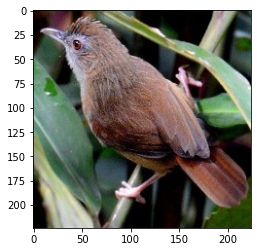

In [29]:
image = plt.imread(BASE_DIR+os.listdir(BASE_DIR)[0]+'/1.jpg')
plt.imshow(image)

image = tf.expand_dims(image,0)
image = tf.cast(image,tf.float32)

#### 1. Data distillation with Pools / Lowering Resolution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


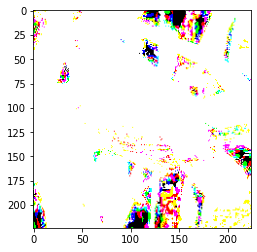

Dims:  (1, 224, 224, 3)


In [53]:
class distiller(tf.keras.Model):
    def __init__(self):
        super(distiller, self).__init__()
        self.layer1 = tf.keras.layers.InputLayer(input_shape=(None,224,224,3))
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(1,1), strides=(1,1))
        self.pool2 = tf.keras.layers.AveragePooling2D(pool_size=(1,1), strides=(1,1))

    def call(self, x):
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.pool1(x)
        x = self.pool2(x)
        return x

example = distiller()

plt.imshow(tf.squeeze(example(image)))
plt.show()
print('Dims: ', example(image).shape)

#### 2. Data distillation with Autoencoders (learning a distilled representation) 